In [814]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import normaltest, shapiro
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [690]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

In [691]:
methods= ["direct_and_pr", "iterative_pr_head_ref_cherry_picked"]

In [692]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [693]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [694]:
methods_df = {"direct_and_pr":direct_and_pr,
             "iterative_pr_head_ref_cherry_picked": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4             |
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 265   |

**Size**

In [695]:
for method in methods:
    print(methods_df[method].shape)

(52, 288)
(52, 288)


**Number burst metrics**

In [696]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [697]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

72
72


**Extracting the dependent variables** 

In [698]:
dep_var_cols = ["post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [699]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]

**Extracting the independent variables**

In [700]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag']

In [701]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [702]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 266)
iterative_pr_head_ref_cherry_picked (52, 266)


### Missing values

In [703]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [704]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [705]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,min_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,...,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs2_burst_size_min,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min,ratio_pr_builds_failed
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,1146.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,11.000000,11.0,11,11,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [706]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [707]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [708]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 236)
iterative_pr_head_ref_cherry_picked (52, 215)


In [709]:
method_uninformative_columns[methods[0]].nunique()

30

In [710]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [711]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

{'canceled_gp1_bs3_n_bursts_min',
 'canceled_gp2_bs1_n_bursts_min',
 'canceled_gp2_bs2_n_bursts_min',
 'canceled_gp2_bs3_n_bursts_min',
 'canceled_gp3_bs1_n_bursts_min',
 'canceled_gp3_bs2_n_bursts_min',
 'canceled_gp3_bs3_n_bursts_min',
 'failed_gp1_bs3_n_bursts_min',
 'failed_gp2_bs1_n_bursts_min',
 'failed_gp2_bs2_n_bursts_min',
 'failed_gp2_bs3_n_bursts_min',
 'failed_gp3_bs1_n_bursts_min',
 'failed_gp3_bs2_n_bursts_min',
 'failed_gp3_bs3_n_bursts_min',
 'not_passed_gp1_bs3_n_bursts_min',
 'not_passed_gp2_bs1_n_bursts_min',
 'not_passed_gp2_bs2_n_bursts_min',
 'not_passed_gp2_bs3_n_bursts_min',
 'not_passed_gp3_bs1_n_bursts_min',
 'not_passed_gp3_bs2_n_bursts_min',
 'not_passed_gp3_bs3_n_bursts_min'}

### Statistical summary

**Method 0**

Not burst metrics

In [712]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,min_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,ratio_pr_builds_failed
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.769804,0.049930,0.107409,0.072858,0.288482,2383.953469,2487.442308,13033.711538,-5837.115385,1651.513973,1675.480769,2745.576923,756.846154,2670.109314,2586.730769,4605.711538,1747.673077,6.983362,4.144231,104.173077,2.634615,6.881471,4.485119,654.942986,0.001201,0.380881,0.201923,63.346154,2.249739,0.618805,532.558161,0.007581,5.449230,2.978306,97.204812,0.000036,19.759538,2.269231,210.980769,116.501444,21.634615,815.923077,2.403846,0.920856,0.115385,30.269231,0.035578
std,0.163330,0.055365,0.081205,0.147760,0.276243,1503.800614,1616.967580,57077.485698,34049.423808,1936.459052,2078.319273,2969.736731,1311.794077,1805.062684,1738.237942,3666.306719,1436.675912,9.520588,9.629070,210.828126,8.324377,14.447417,13.249594,2708.510067,0.001537,1.498247,1.456088,240.937538,5.152182,0.843577,2588.488968,0.025895,7.201269,6.479358,215.832812,0.000125,21.123590,7.003124,522.451067,107.719442,20.219171,1024.539549,5.584501,1.231825,0.582552,132.535177,0.042521
min,0.000000,0.000000,0.000000,0.000000,0.000000,832.235294,940.000000,1187.000000,-218596.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.087503,0.000000,0.188000,0.000000,0.000000,0.000000,0.000000,0.069257,0.000456,0.161137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.704412,0.000000,0.050331,0.000000,0.000000,1211.299342,1307.750000,2332.750000,0.000000,482.916667,399.625000,735.500000,51.750000,1385.782598,1359.750000,2318.250000,831.750000,3.125000,1.000000,9.000000,1.000000,0.455791,0.150991,3.750000,0.000000,0.000000,0.000000,0.000000,0.620497,0.042795,5.000000,0.000000,0.090024,0.000492,1.250000,0.000000,1.000000,0.000000,2.750000,21.307143,6.375000,57.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.773504,0.033269,0.101282,0.034585,0.267573,1649.598110,1784.750000,3220.500000,48.000000,927.500000,810.500000,1468.500000,258.500000,2071.239262,1914.250000,2998.000000,1211.500000,4.344332,1.500000,20.500000,1.000000,1.378893,0.714752,18.500000,0.000000,0.026261,0.000000,1.500000,1.222579,0.181918,9.000000,0.000000,1.804817,0.001272,31.500000,0.000000,9.533924,0.000000,70.500000,70.754580,13.250000,734.500000,0.000000,0.117865,0.000000,6.000000,0.000000
75%,0.859524,0.098817,0.154858,0

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [713]:
methods_indep_var[methods[0]].shape

(52, 236)

In [714]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,...,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,5

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [715]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [716]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

direct_and_pr 142
iterative_pr_head_ref_cherry_picked 127


**How many columns to remove due to perfect correlation are burst metric?**

In [717]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

direct_and_pr 1.0
iterative_pr_head_ref_cherry_picked 0.9921259842519685


There are a couple not burst features

In [718]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

[]

In [720]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['min_n_builds_per_pull_request']

In [721]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

min_n_builds_per_pull_request :
 not_passed_gp1_bs2_n_bursts_min    1.0
canceled_gp1_bs2_n_bursts_min      1.0
canceled_gp1_bs1_n_bursts_min      1.0
failed_gp1_bs1_n_bursts_min        1.0
failed_gp1_bs2_n_bursts_min        1.0
not_passed_gp1_bs1_n_bursts_min    1.0
dtype: float64


Remove the perfectly correlated columns

In [722]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(52, 94)
(52, 88)


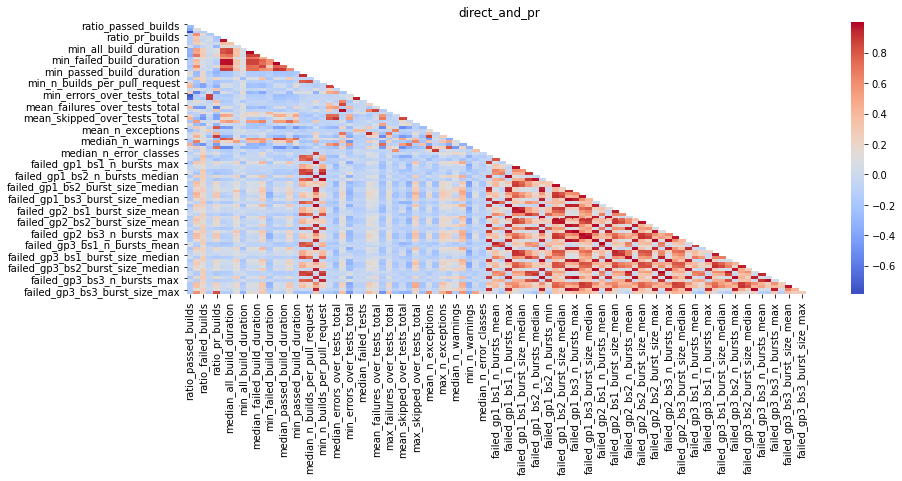

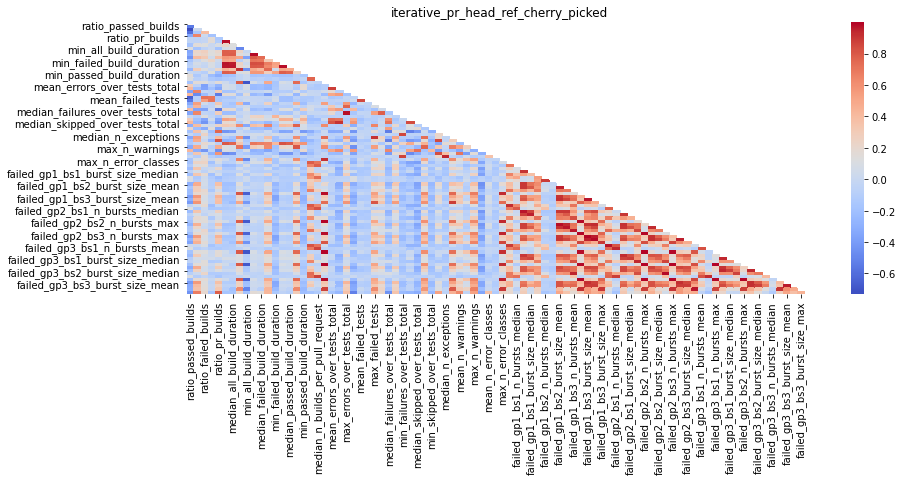

In [723]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [724]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

{'failed_gp1_bs1_n_bursts_max',
 'failed_gp1_bs2_burst_size_max',
 'failed_gp1_bs2_n_bursts_max',
 'failed_gp2_bs1_n_bursts_max',
 'failed_gp2_bs2_burst_size_max',
 'failed_gp3_bs2_burst_size_max',
 'failed_gp3_bs3_n_bursts_min',
 'min_n_builds_per_pull_request'}

### Normal distribution

In [823]:
method_normal_distributed_features = {}
for method in methods:
    shapiro_feat = methods_indep_var[method].apply(lambda x: shapiro(x)).T
    shapiro_feat.columns = ["statistic", "pval"]
    normal_feat = methods_indep_var[method].apply(lambda x: normaltest(x)).T
    normal_feat.columns = ["statistic", "pval"]
    method_normal_distributed_features[method] = list(shapiro_feat[shapiro_feat.pval > 0.05].index)\
    + list(normal_feat[normal_feat.pval > 0.05].index)

<Figure size 1008x360 with 0 Axes>

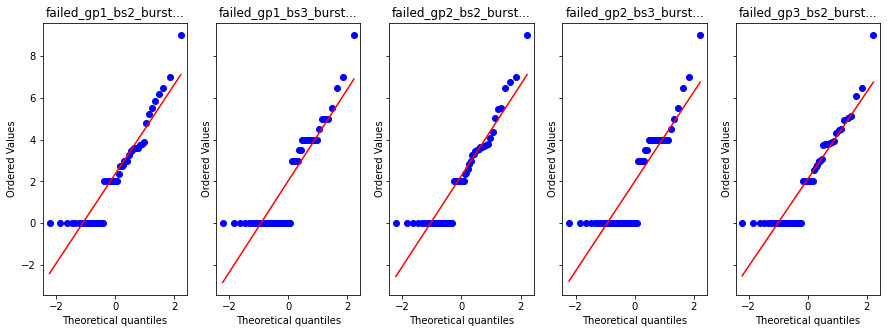

In [933]:
plt.figure()
for method in methods:
    df = methods_indep_var[method]
    normal_features = method_normal_distributed_features[method]
    if(len(normal_features) < 1):
        continue
    fig, axes = plt.subplots(nrows=1, ncols=len(normal_features), sharey=True, figsize=(15.0, 5.0))
    for i, feat in enumerate(normal_features):
        scipy.stats.probplot(df[feat], dist="norm", plot=axes[i])
        axes[i].set_title(feat[:20]+"...")
plt.savefig(f"{figure_folder}/dataset_preprocessing/qq-plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

A visual test does not seem to confirm that these features are indeed normally distributed. We conclude that none of our features are normally distributed.

### Correlated features

<Figure size 1008x360 with 0 Axes>

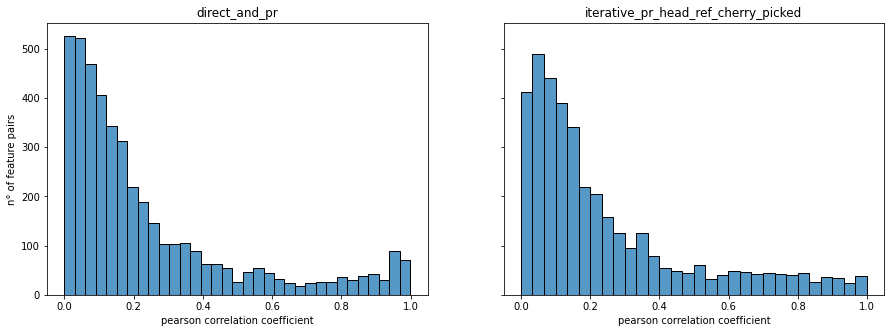

In [725]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="pearson correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [726]:
methods_correlated_features[methods[1]].head(10)

failed_gp2_bs2_n_bursts_max     failed_gp3_bs2_n_bursts_max       0.999
max_n_builds_per_pull_request   failed_gp3_bs1_n_bursts_max       0.999
failed_gp2_bs3_n_bursts_max     failed_gp3_bs3_n_bursts_max       0.999
failed_gp1_bs3_n_bursts_max     failed_gp2_bs3_n_bursts_max       0.998
failed_gp3_bs1_n_bursts_max     failed_gp3_bs2_n_bursts_max       0.997
failed_gp2_bs2_n_bursts_max     failed_gp3_bs1_n_bursts_max       0.997
failed_gp1_bs3_n_bursts_max     failed_gp3_bs3_n_bursts_max       0.996
max_n_builds_per_pull_request   failed_gp3_bs2_n_bursts_max       0.996
                                failed_gp2_bs2_n_bursts_max       0.995
failed_gp1_bs3_burst_size_mean  failed_gp2_bs3_burst_size_mean    0.994
dtype: float64

In [727]:
methods_correlated_features[methods[0]].head(10)

failed_gp1_bs1_n_bursts_max    failed_gp3_bs1_n_bursts_max      0.999
failed_gp2_bs1_n_bursts_max    failed_gp3_bs1_n_bursts_max      0.999
failed_gp1_bs1_n_bursts_max    failed_gp2_bs1_n_bursts_max      0.998
failed_gp2_bs2_burst_size_max  failed_gp2_bs3_burst_size_max    0.998
failed_gp3_bs2_burst_size_max  failed_gp3_bs3_burst_size_max    0.998
failed_gp1_bs2_burst_size_max  failed_gp1_bs3_burst_size_max    0.998
failed_gp1_bs2_n_bursts_max    failed_gp2_bs2_n_bursts_max      0.997
failed_gp2_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max      0.996
failed_gp2_bs3_n_bursts_mean   failed_gp3_bs3_n_bursts_mean     0.995
failed_gp1_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max      0.995
dtype: float64

**Remove highly correlated features?**

methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    for pair in methods_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    #print(method, len(cols_to_remove))

for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [826]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    x = methods_indep_var[method].apply(lambda x:\
                                scipy.stats.pearsonr(x, corr_col)).T
    x.columns = ["pearson_corr", "pval"]
    methods_pearson_corr_post_release_bugs[method] = x

    x = methods_indep_var[method].apply(lambda x:\
                                scipy.stats.spearmanr(x, corr_col)).T
    x.columns = ["spearman_corr", "pval"]
    methods_spearman_corr_post_release_bugs[method] = x

In [859]:
feature_categories = ["ratio_(.*)_builds",
                     "(.*)_(.*)_build_duration",
                     "(.*)_n_builds_per_pull_request",
                     "(.*)_errors_over_tests_total",
                     "(.*)_failed_tests",
                     "(.*)_failures_over_tests_total",
                     "(.*)_skipped_over_tests_total",
                     "(.*)_n_exceptions",
                     "(.*)_n_warnings",
                     "(.*)_n_error_classes",
                     "(.*)_burst_size",
                     "(.*)_n_bursts"]

In [934]:
import re
for cat in feature_categories:
    print("-"*10)
    print(cat)
    for method in methods:
        x = methods_spearman_corr_post_release_bugs[method]
        x = x[x.pval < 0.05]
        print(method, "\n", x[[True if re.search(cat, s) else False for s in x.index]].spearman_corr.sort_values(ascending=False).to_latex())

----------
ratio_(.*)_builds
direct_and_pr 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_canceled\_builds &       0.275835 \\
ratio\_passed\_builds   &      -0.279955 \\
\bottomrule
\end{tabular}

iterative_pr_head_ref_cherry_picked 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_canceled\_builds  &       0.311919 \\
ratio\_pr\_builds\_failed &       0.302805 \\
ratio\_failed\_builds    &       0.293870 \\
ratio\_passed\_builds    &      -0.402567 \\
\bottomrule
\end{tabular}

----------
(.*)_(.*)_build_duration
direct_and_pr 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
max\_failed\_build\_duration &       0.370626 \\
min\_all\_build\_duration    &      -0.450631 \\
\bottomrule
\end{tabular}

iterative_pr_head_ref_cherry_picked 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
max\_failed\_build\_duration &       0.442413 \\
min\_all\_build\_duration    &      -0.398608 \\
\bottomrule
\end{tabular}

------

**Method 0 correlation analysis**

In [733]:
df = methods_pearson_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(10)

0.25505167509828985

<AxesSubplot:ylabel='Frequency'>

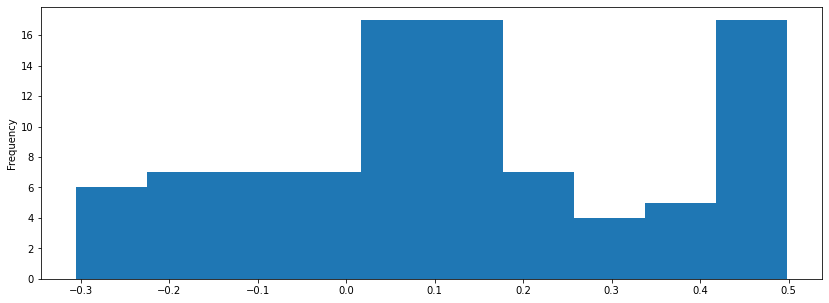

In [736]:
df.plot(kind="hist")

<AxesSubplot:>

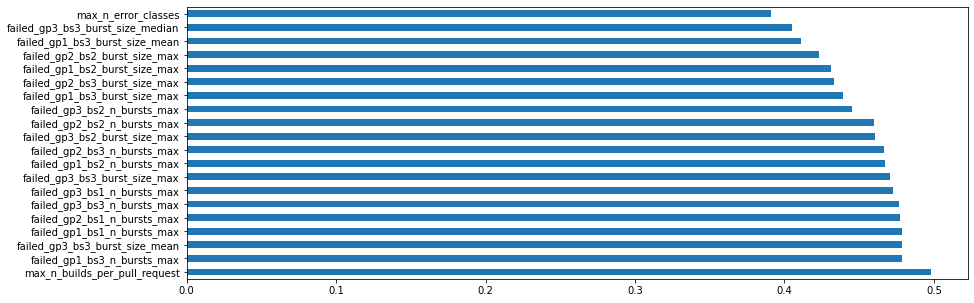

In [730]:
df = methods_pearson_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(20).plot(kind="barh")
#[[col for col in df.index if not "burst" in col]]

<AxesSubplot:ylabel='Frequency'>

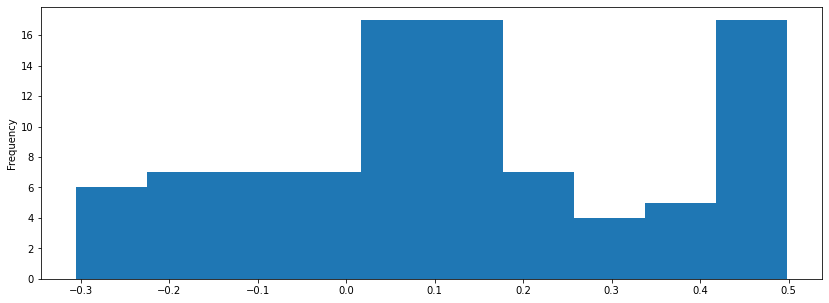

In [737]:
df.plot(kind="hist")

**Spearman correlation method0**

In [738]:
spearman_corr = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
spearman_corr = df.reindex(df.abs().sort_values(ascending=False).index)
spearman_corr.head(10)

max_n_builds_per_pull_request     0.497782
failed_gp1_bs3_n_bursts_max       0.478835
failed_gp3_bs3_burst_size_mean    0.478759
failed_gp1_bs1_n_bursts_max       0.478402
failed_gp2_bs1_n_bursts_max       0.477622
failed_gp3_bs3_n_bursts_max       0.476412
failed_gp3_bs1_n_bursts_max       0.472924
failed_gp3_bs3_burst_size_max     0.470321
failed_gp1_bs2_n_bursts_max       0.467268
failed_gp2_bs3_n_bursts_max       0.466594
dtype: float64

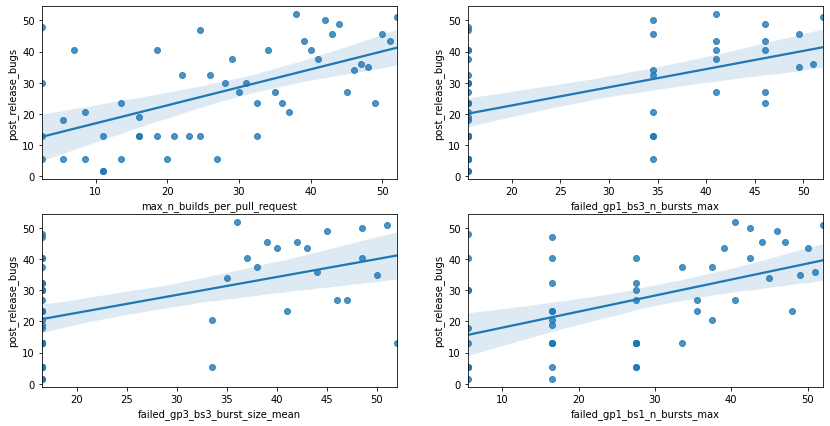

In [739]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.0, 7.0))
axes = axes.flatten()
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])

Text(0.5, 1.0, 'Top 20 spearman rank correlations with post release bugs (no burst metrics)')

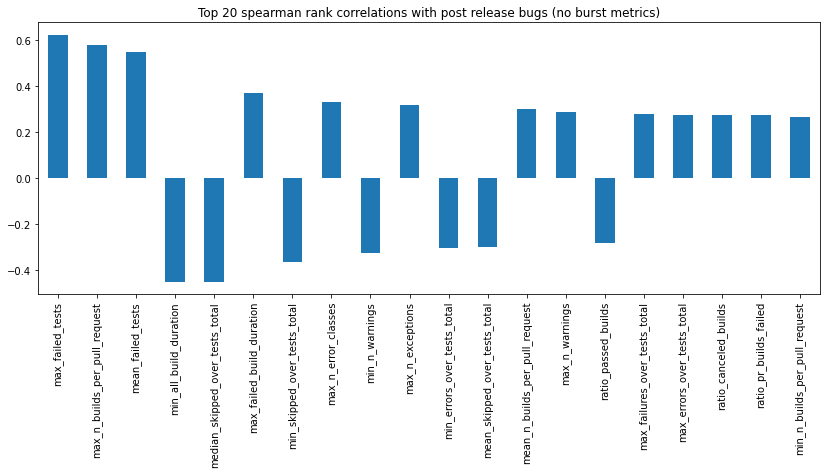

In [740]:
df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='min_all_build_duration', ylabel='post_release_bugs'>

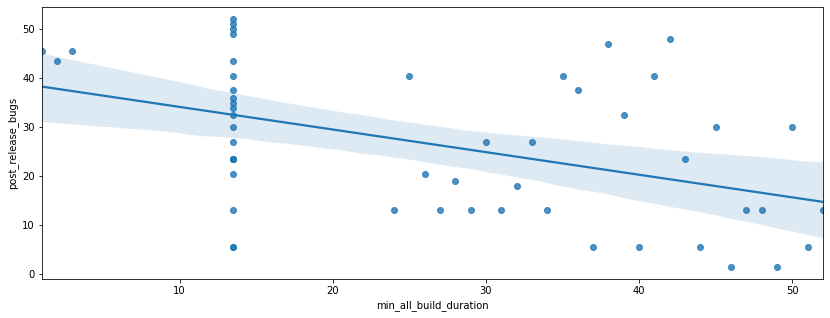

In [864]:
df_ind = methods_indep_var[methods[0]]
df_dep = methods_dep_var[methods[0]]
sns.regplot(df_ind.min_all_build_duration.rank(), df_dep.post_release_bugs.rank())

In [742]:
sol

failed_gp2_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max         0.999
max_n_builds_per_pull_request  failed_gp3_bs1_n_bursts_max         0.999
failed_gp2_bs3_n_bursts_max    failed_gp3_bs3_n_bursts_max         0.999
failed_gp1_bs3_n_bursts_max    failed_gp2_bs3_n_bursts_max         0.998
failed_gp3_bs1_n_bursts_max    failed_gp3_bs2_n_bursts_max         0.997
                                                                   ...  
median_n_warnings              failed_gp1_bs2_n_bursts_median      0.001
mean_skipped_over_tests_total  failed_gp2_bs1_burst_size_median    0.000
                               failed_gp1_bs1_burst_size_median    0.000
median_all_build_duration      failed_gp3_bs2_n_bursts_mean        0.000
median_failed_build_duration   failed_gp3_bs2_n_bursts_mean        0.000
Length: 3828, dtype: float64

**Method 1 correlation analysis**

In [743]:
df = methods_pearson_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(10)

failed_gp2_bs3_burst_size_max     0.488292
failed_gp3_bs3_burst_size_mean    0.441076
ratio_passed_builds              -0.429787
failed_gp3_bs3_burst_size_max     0.417021
failed_gp2_bs3_burst_size_mean    0.401014
ratio_canceled_builds             0.397555
failed_gp1_bs3_burst_size_mean    0.397551
failed_gp1_bs3_burst_size_max     0.389691
failed_gp1_bs2_n_bursts_mean      0.349815
failed_gp3_bs2_burst_size_mean    0.337927
dtype: float64

In [757]:
df = methods_spearman_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)

max_failed_tests
max_n_builds_per_pull_request
mean_failed_tests
failed_gp3_bs1_n_bursts_max
failed_gp2_bs2_n_bursts_max
failed_gp3_bs3_n_bursts_max
failed_gp2_bs3_n_bursts_max
failed_gp1_bs3_n_bursts_max
failed_gp3_bs3_burst_size_max
failed_gp2_bs3_burst_size_max
failed_gp3_bs2_n_bursts_max
failed_gp1_bs3_burst_size_max
failed_gp1_bs2_n_bursts_mean
max_failed_build_duration
failed_gp1_bs1_n_bursts_mean
failed_gp3_bs3_burst_size_mean
max_n_error_classes
median_skipped_over_tests_total
failed_gp1_bs1_burst_size_mean
max_n_exceptions
ratio_passed_builds
failed_gp1_bs3_burst_size_mean
min_all_build_duration
mean_n_builds_per_pull_request
failed_gp2_bs3_burst_size_mean
failed_gp1_bs2_burst_size_mean
failed_gp3_bs2_burst_size_mean
failed_gp2_bs2_n_bursts_mean
failed_gp1_bs3_n_bursts_mean
failed_gp3_bs3_n_bursts_mean
failed_gp3_bs3_burst_size_median
failed_gp3_bs1_burst_size_mean
min_skipped_over_tests_total
failed_gp3_bs1_n_bursts_mean
failed_gp2_bs2_burst_size_mean
failed_gp3_bs2_n_bursts_

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
58    None
59    None
60    None
61    None
62    None
63    None
64    None
65    None
66    None
67    None
68    None
69    None
70    None
71    None
72    None
73    None
74    None
75    None
76    None
77    None
78    None
79    None
80    None
81    None
82    None
83    None
84    None
85    None
86    None
87    None
Name: feature, dtype: object

<AxesSubplot:>

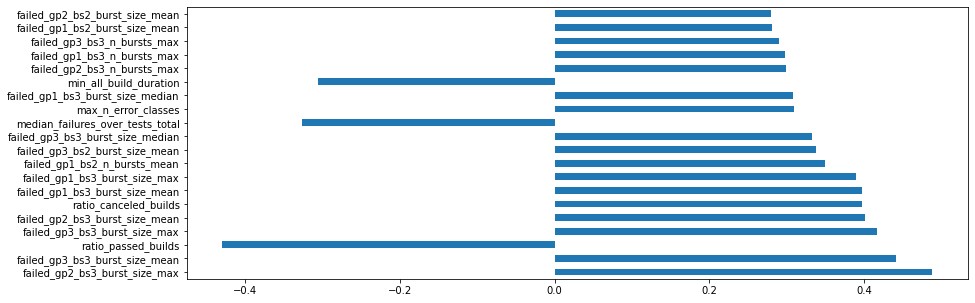

In [49]:
df = methods_pearson_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(20).plot(kind="barh")
#[[col for col in df.index if not "burst" in col]]

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='max_failed_tests', ylabel='post_release_bugs'>

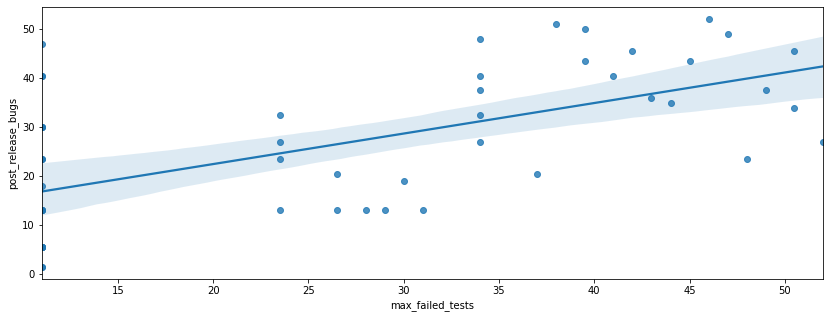

In [747]:
df_ind = methods_indep_var[methods[1]]
df_dep = methods_dep_var[methods[1]]
sns.regplot(df_ind.max_failed_tests.rank(), df_dep.post_release_bugs.rank())

In [750]:
scipy.stats.spearmanr(df_ind.max_failed_tests, df_dep.post_release_bugs).pvalue < 0.05

True

<AxesSubplot:ylabel='Frequency'>

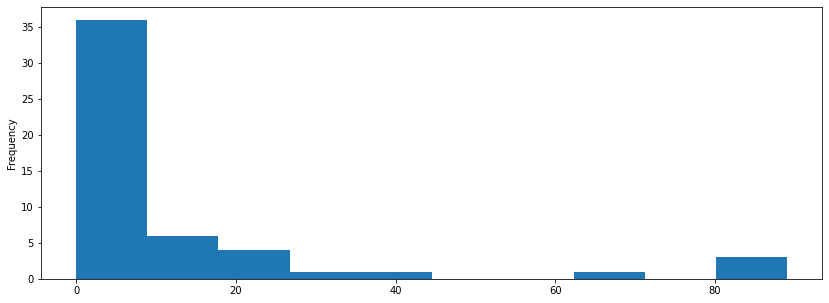

In [643]:
df_ind.failed_gp2_bs3_burst_size_max.plot(kind="hist")

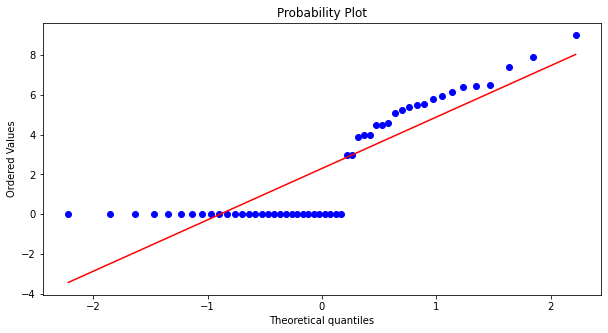

In [648]:
import scipy
fig = plt.figure(figsize=(10,5))
scipy.stats.probplot(df_ind.failed_gp3_bs3_burst_size_mean, dist="norm", plot=plt)
plt.show()

In [649]:
scipy.stats.pearsonr(df_ind.failed_gp3_bs3_burst_size_mean, df_dep.post_release_bugs)

(0.4410760305900777, 0.0010644828456098207)

Text(0.5, 1.0, 'Top 20 spearman rank correlations with post release bugs (no burst metrics)')

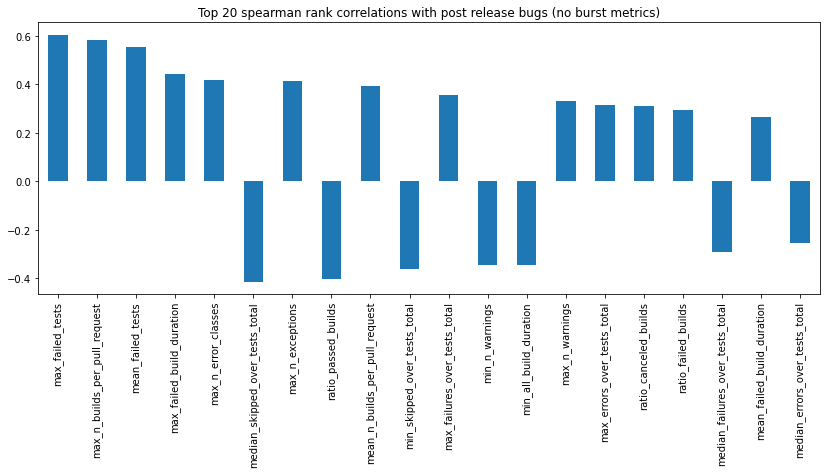

In [50]:
df = methods_spearman_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='failed_gp2_bs3_burst_size_max', ylabel='post_release_bugs'>

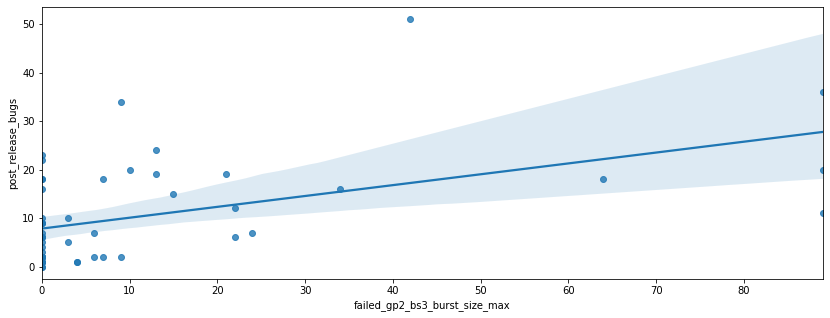

In [51]:
df_ind = methods_indep_var[methods[1]]
df_dep = methods_dep_var[methods[1]]
sns.regplot(df_ind.failed_gp2_bs3_burst_size_max, df_dep.post_release_bugs)

### Play with feature selection

In [445]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [446]:
fs = SelectKBest(score_func=f_regression, k='all')

In [447]:
X_train = methods_indep_var[methods[1]][:-2]
y_train = methods_dep_var[methods[1]][:-2].fix_time

In [448]:
fs.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x126a29ca0>)

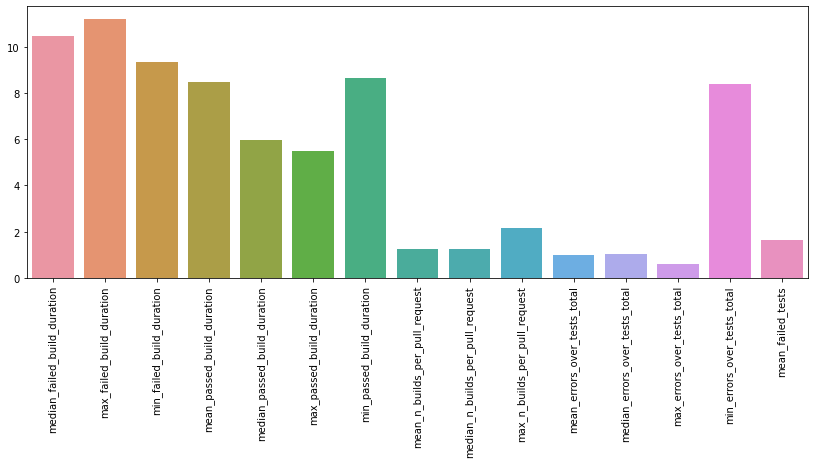

In [449]:
ax = sns.barplot(x=X_train.columns[10:25], y=fs.scores_[10:25])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

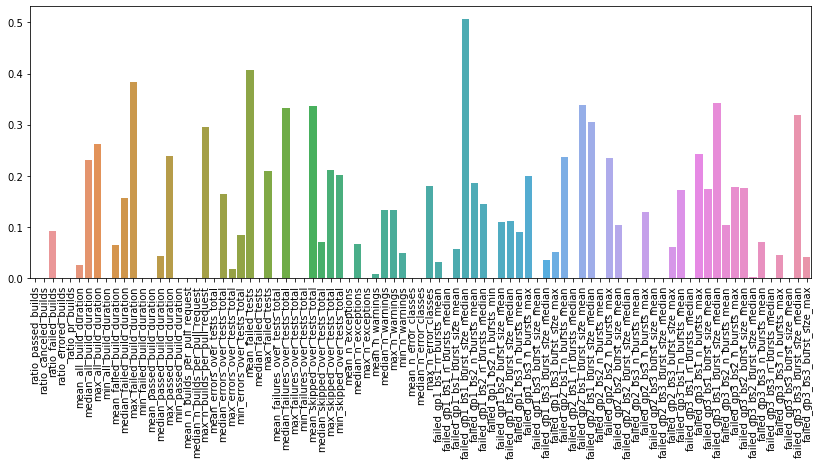

In [450]:
ax = sns.barplot(y=mutual_information, x=X_train.columns)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [451]:
from sklearn.tree import DecisionTreeRegressor

clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor()

<AxesSubplot:>

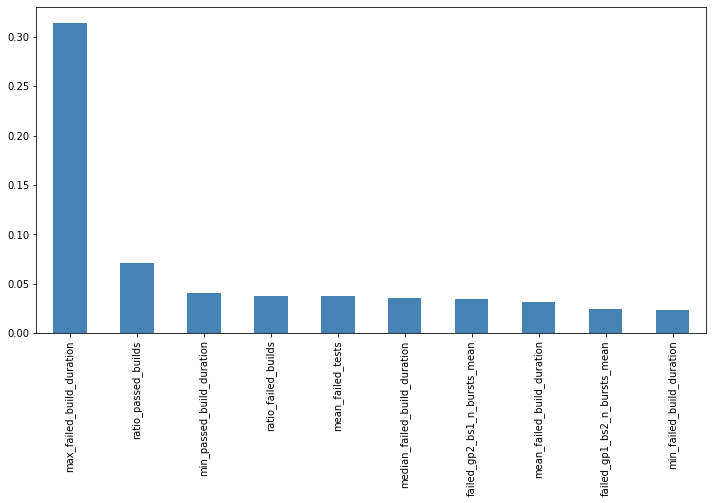

In [452]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)\
.plot.bar(color='steelblue', figsize=(12, 6))

In [453]:
from sklearn.feature_selection import RFECV

clf = DecisionTreeRegressor()
trans = RFECV(clf)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_RFECV = X_train.columns[trans.get_support()].values
columns_retained_RFECV

array(['max_failed_build_duration'], dtype=object)

In [454]:
len(columns_retained_RFECV)

1

<AxesSubplot:>

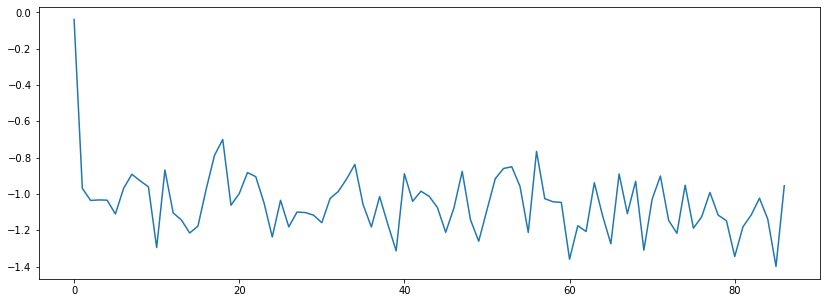

In [455]:
sns.lineplot(y=trans.grid_scores_, x=range(0, len(trans.grid_scores_)))

In [456]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [865]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [458]:
model = RandomForestRegressor()
rfecv = RFECV(estimator=model, step=0.2, cv=KFold(20), scoring="neg_mean_absolute_error")
rfecv.fit(X_train_scaled, y_train)
rfecv.grid_scores_
model = RandomForestRegressor()
rfecv = RFECV(estimator=model, step=0.2, cv=KFold(20), scoring="neg_mean_absolute_error")
rfecv.fit(X_train_scaled, y_train)
rfecv.grid_scores_
array([-16.21722398, -19.60551888, -17.1653021 , -16.88096433,
       -16.83161606, -17.40892695, -17.19289982])
model = RandomForestRegressor()
rfecv = RFECV(estimator=model, step=0.2, cv=KFold(20), scoring="neg_mean_absolute_error")
rfecv.fit(X_train_scaled, y_train)
rfecv.grid_scores_
model = RandomForestRegressor()
rfecv = RFECV(estimator=model, step=0.2, cv=KFold(20), scoring="neg_mean_absolute_error")
rfecv.fit(X_train_scaled, y_train)
rfecv.grid_scores_
array([-16.21722398, -19.60551888, -17.1653021 , -16.88096433,
       -16.83161606, -17.40892695, -17.19289982])


array([-16.21722398, -19.60551888, -17.1653021 , -16.88096433,
       -16.83161606, -17.40892695, -17.19289982])

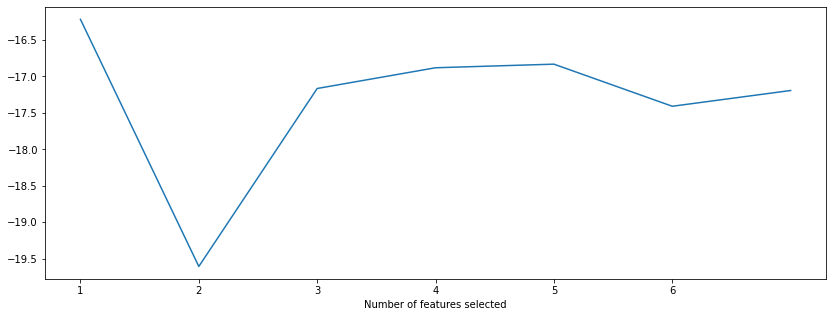

In [459]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
#plt.ylabel("Average validation fold R^2 value")
plt.xticks(np.arange(0, len(rfecv.grid_scores_), step=1))
ax = plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [460]:
rfecv.n_features_

1

In [461]:
rfecv.support_

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [462]:
X_train.columns[rfecv.support_]

Index(['max_failed_build_duration'], dtype='object')

In [463]:
rfecv.transform(X_train)

array([[ 5340.],
       [ 7412.],
       [ 8420.],
       [ 8595.],
       [ 6780.],
       [ 4656.],
       [ 8342.],
       [10009.],
       [ 6468.],
       [ 6986.],
       [10228.],
       [ 6600.],
       [ 2914.],
       [10009.],
       [ 1123.],
       [ 6955.],
       [ 7819.],
       [ 1346.],
       [ 1072.],
       [10009.],
       [ 2372.],
       [ 1871.],
       [ 2427.],
       [ 1547.],
       [ 1435.],
       [  561.],
       [  963.],
       [ 1216.],
       [ 1325.],
       [  826.],
       [ 1133.],
       [ 2486.],
       [ 1361.],
       [  602.],
       [    0.],
       [ 1229.],
       [ 1523.],
       [ 1779.],
       [ 2566.],
       [ 1368.],
       [ 1435.],
       [ 1571.],
       [    0.],
       [    0.],
       [    0.],
       [ 1384.],
       [ 1617.],
       [    0.],
       [    0.],
       [    0.]])

In [465]:
y_train.describe()

count    50.000000
mean     31.356608
std      26.244172
min       0.000000
25%       7.174274
50%      24.536327
75%      53.679148
max      92.887575
Name: fix_time, dtype: float64

In [894]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVR

In [467]:
train_index

array([ 1,  2,  4,  5,  6,  9, 11, 15, 18, 21, 26, 28, 29, 31, 33, 35, 36,
       37, 38, 40, 41, 42, 43, 44, 45])

In [468]:
kf = KFold(n_splits=2, random_state=None, shuffle=True)
train_index, test_index = kf.split(X_train)
model = SVR(kernel='rbf')

for train_index, test_index in kf.split(X_train):
    y_pred = model.fit(X_train.loc[train_index],y_train.loc[train_index])\
    .predict(X_train.loc[test_index])
    print(mean_absolute_error(y_pred, y_train[test_index]))

26.427793570108005
23.314323685342398


In [469]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
print("mean", mean_absolute_error(dummy_reg.predict(X_train), y_train))
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
print("median" , mean_absolute_error(dummy_reg.predict(X_train), y_train))

mean 22.43927290529786
median 21.91801318258966


### PCA

In [525]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = methods_indep_var[methods[1]]
y = methods_dep_var[methods[1]].post_release_bugs
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents\
                           , columns = ['principal component 1', 'principal component 2'])

In [526]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [539]:
finalDf

,principal component 1,principal component 2,post_release_bugs
0,-22852.091801,603.941800,36.0
1,-20917.301521,8881.693279,12.0
2,387112.301637,3045.720506,15.0
3,-11264.564998,12092.416307,6.0
4,-17706.832674,9071.723048,34.0
5,-21204.446816,8474.480082,9.0
6,-19665.588349,9195.324220,2.0
7,6806.986308,11968.104400,24.0
8,-17606.281277,11278.990362,6.0
9,-20304.702797,10028.026339,2.0


In [527]:
pca.explained_variance_ratio_

array([0.99398688, 0.00325102])

In [528]:
X_pca = pca.transform(X)

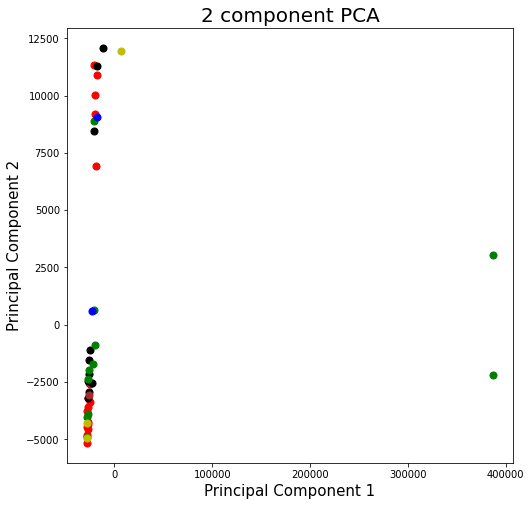

In [545]:
#plt.scatter(X_pca, y)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r','black', 'g','y', 'b', 'brown']
ranges = [(0,5), (5,10),(10,20),(20,30),(30,40),(40,60)]
for rang, color in zip(ranges, colors):
    indicesToKeep = (y > rang[0]) & (y < rang[1])
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

In [523]:
model = LinearRegression().fit(X_pca, y)

In [510]:
pd.Series(model.coef_, X.columns).sort_values(ascending=False)

failed_gp2_bs1_burst_size_median    6.604254
failed_gp3_bs1_n_bursts_mean        5.480106
failed_gp3_bs2_burst_size_mean      5.437288
failed_gp2_bs1_burst_size_mean      4.074067
median_n_error_classes              4.017075
median_skipped_over_tests_total     3.879288
failed_gp2_bs2_n_bursts_mean        3.077496
failed_gp3_bs3_n_bursts_max         3.015379
ratio_errored_builds                2.860561
mean_failures_over_tests_total      2.781357
failed_gp2_bs2_n_bursts_max         2.437288
failed_gp2_bs2_burst_size_mean      2.407921
failed_gp1_bs1_n_bursts_mean        2.285160
failed_gp3_bs2_n_bursts_max         2.228543
failed_gp1_bs3_burst_size_max       1.542344
failed_gp2_bs1_n_bursts_mean        1.323617
failed_gp2_bs3_burst_size_mean      1.112495
mean_errors_over_tests_total        1.035356
failed_gp3_bs3_n_bursts_median      0.922254
median_failed_tests                 0.876908
median_n_warnings                   0.804152
failed_gp3_bs2_n_bursts_mean        0.695342
failed_gp1

In [503]:
model.intercept_

17.71075920462229

In [547]:
y_bin = y > y.median()

In [588]:
model = RandomForestClassifier()
cross_val_score(model, X, y_bin, cv=KFold(n_splits=20, random_state=2, shuffle=True), scoring="precision").mean()

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexincerti/Library/Python/3.8/lib/python/site-pack

0.5583333333333333

In [579]:
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
dummy_clas = DummyClassifier(strategy="uniform")
dummy_clas.fit(X, y_bin)
print("uniform", f1_score(dummy_clas.predict(X), y_bin))
dummy_clas = DummyClassifier(strategy="most_frequent")
dummy_clas.fit(X_train, y_train)
print("most_frequent" , f1_score(dummy_clas.predict(X), y_bin))

uniform 0.5106382978723404
most_frequent 0.0


In [590]:
y_cat = pd.qcut(y, q=[0, .25, .75, 1], labels=['small', 'medium', 'large'])

In [607]:
model = RandomForestClassifier()
rfecv = RFECV(estimator=model, step=0.2, cv=KFold(20, shuffle=True), scoring="accuracy")
rfecv.fit(X, y_cat)
rfecv.grid_scores_

array([0.40833333, 0.45      , 0.45833333, 0.4       , 0.425     ,
       0.36666667, 0.425     ])

In [611]:
from sklearn.dummy import DummyClassifier
dummy_clas = DummyClassifier(strategy="uniform")
dummy_clas.fit(X, y_cat)
print("uniform", accuracy_score(dummy_clas.predict(X), y_cat))
dummy_clas = DummyClassifier(strategy="most_frequent")
dummy_clas.fit(X, y_cat)
print("most_frequent" , accuracy_score(dummy_clas.predict(X), y_cat))

uniform 0.36538461538461536
most_frequent 0.4807692307692308


In [609]:
dummy_clas.predict(X)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [599]:
rfecv.predict(X)

array(['large', 'medium', 'medium', 'medium', 'large', 'medium', 'small',
       'large', 'small', 'small', 'small', 'medium', 'small', 'medium',
       'medium', 'large', 'large', 'small', 'small', 'large', 'medium',
       'medium', 'large', 'medium', 'medium', 'small', 'small', 'small',
       'small', 'small', 'small', 'large', 'medium', 'small', 'small',
       'medium', 'medium', 'medium', 'medium', 'medium', 'small',
       'medium', 'small', 'small', 'small', 'medium', 'medium', 'small',
       'small', 'medium', 'medium', 'small'], dtype=object)

In [603]:
pd.DataFrame([y_cat, rfecv.predict(X)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
post_release_bugs,large,medium,medium,medium,large,medium,small,large,medium,small,small,medium,small,medium,small,large,large,medium,small,large,medium,medium,large,medium,medium,small,medium,small,small,small,small,large,medium,large,medium,medium,medium,medium,medium,medium,large,medium,small,small,small,medium,medium,small,small,medium,medium,small
Unnamed 0,large,medium,medium,medium,large,medium,small,large,small,small,small,medium,small,medium,medium,large,large,small,small,large,medium,medium,large,medium,medium,small,small,small,small,small,small,large,medium,small,small,medium,medium,medium,medium,medium,small,medium,small,small,small,medium,medium,small,small,medium,medium,small


In [605]:
rfecv.estimator_.fit()

RandomForestClassifier()

In [614]:
model = RandomForestClassifier()
rfecv = RFECV(estimator=model, step=0.2, cv=KFold(20), scoring="accuracy")
rfecv.fit(X, y_cat)
rfecv.grid_scores_

array([0.36666667, 0.45      , 0.48333333, 0.44166667, 0.40833333,
       0.38333333, 0.425     ])

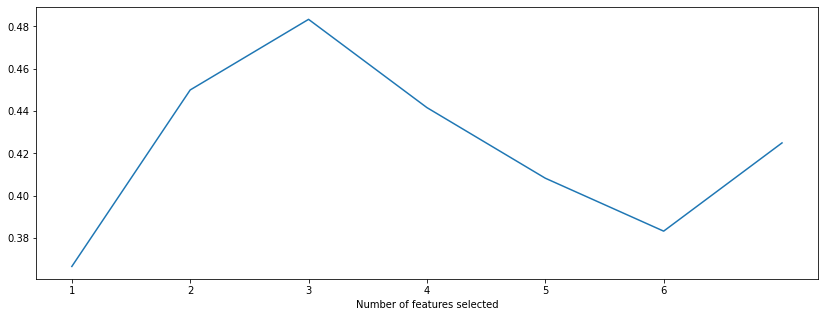

In [615]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
#plt.ylabel("Average validation fold R^2 value")
plt.xticks(np.arange(0, len(rfecv.grid_scores_), step=1))
ax = plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [616]:
X.columns[rfecv.support_]

Index(['ratio_pr_builds', 'max_all_build_duration',
       'mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'mean_passed_build_duration',
       'min_passed_build_duration', 'mean_n_builds_per_pull_request',
       'max_n_builds_per_pull_request', 'mean_errors_over_tests_total',
       'mean_failed_tests', 'max_failed_tests',
       'mean_failures_over_tests_total', 'mean_skipped_over_tests_total',
       'median_skipped_over_tests_total', 'max_skipped_over_tests_total',
       'median_n_warnings', 'mean_n_error_classes',
       'failed_gp3_bs1_n_bursts_max'],
      dtype='object')

In [618]:
X_transformed = rfecv.transform(X)

In [630]:
model = RandomForestClassifier()
cross_val_score(model, X_transformed, y_cat, cv=KFold(n_splits=20, random_state=2, shuffle=True), scoring="accuracy").mean()

0.45

In [868]:
from sklearn.dummy import DummyClassifier
dummy_clas = DummyClassifier(strategy="uniform")
dummy_clas.fit(X, y_cat)
print("uniform", accuracy_score(dummy_clas.predict(X), y_cat))
dummy_clas = DummyClassifier(strategy="most_frequent")
dummy_clas.fit(X, y_cat)
print("most_frequent" , accuracy_score(dummy_clas.predict(X), y_cat))

uniform 0.25
most_frequent 0.4807692307692308


In [871]:
model = RandomForestClassifier()
acc = cross_val_score(model, X_transformed, y_cat, cv=LeaveOneOut(), scoring="accuracy")

<AxesSubplot:>

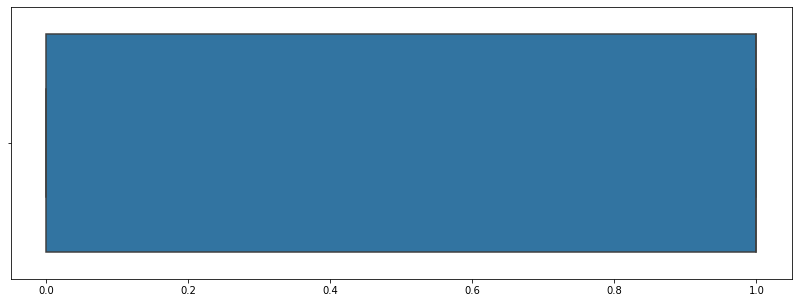

In [873]:
sns.boxplot(x=acc)

In [899]:
model = RandomForestRegressor()
acc = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring="neg_mean_absolute_error")

<AxesSubplot:>

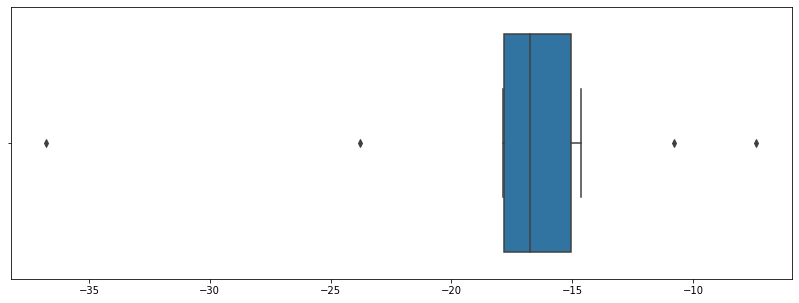

In [900]:
sns.boxplot(x=acc)

In [901]:
acc.mean()

-17.86078891477801

<AxesSubplot:xlabel='fix_time'>

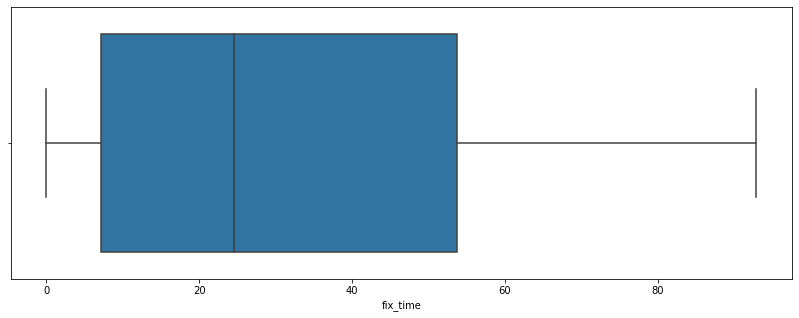

In [902]:
sns.boxplot(x=y_train)

In [923]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
print("median" , mean_absolute_error(dummy_reg.predict(X_train), y_train))
median_predict = dummy_reg.predict(X_train)

median 21.91801318258966


array([24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661,
       24.53632661, 24.53632661, 24.53632661, 24.53632661, 24.53632661])

In [921]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
print("mean" , mean_absolute_error(dummy_reg.predict(X_train), y_train))
mean_predict = dummy_reg.predict(X_train)

mean 22.43927290529786


<AxesSubplot:xlabel='fix_time'>

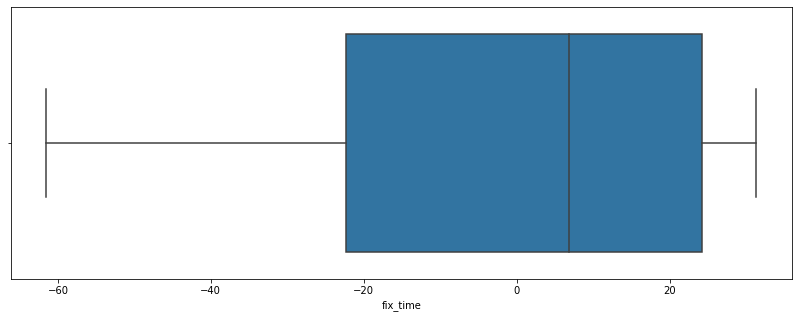

In [905]:
sns.boxplot(x = dummy_reg.predict(X_train) - y_train)

In [924]:
df

,RandomForestRegressor,Mean,Median
0,-17.867376,31.356608,24.536327
1,-36.767825,31.356608,24.536327
2,-16.265979,31.356608,24.536327
3,-10.778934,31.356608,24.536327
4,-23.781709,31.356608,24.536327
5,-14.622642,31.356608,24.536327
6,-7.374586,31.356608,24.536327
7,-16.545293,31.356608,24.536327
8,-17.655168,31.356608,24.536327
9,-16.948378,31.356608,24.536327


<AxesSubplot:>

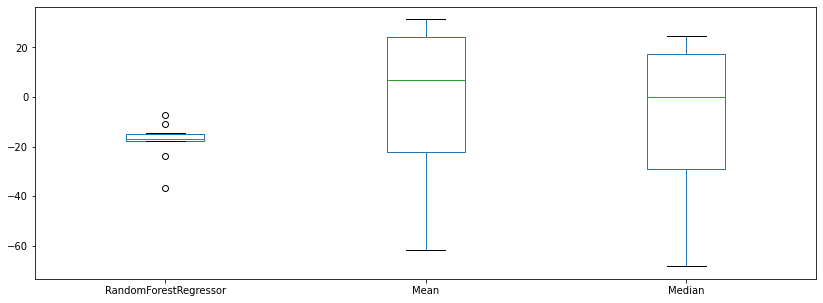

In [925]:
df = pd.DataFrame([acc, mean_predict - y_train, median_predict-y_train]).T
df.columns=["RandomForestRegressor","Mean", "Median"]
df.plot(kind="box")

In [919]:
pd.Series(model.fit(X_train_scaled, y_train).feature_importances_, index=X.columns).sort_values(ascending=False)

max_failed_build_duration           0.290168
min_passed_build_duration           0.079475
ratio_passed_builds                 0.070966
mean_failed_tests                   0.042960
ratio_failed_builds                 0.039636
median_failed_build_duration        0.036719
min_failed_build_duration           0.034782
failed_gp2_bs1_n_bursts_mean        0.027596
mean_failed_build_duration          0.024944
mean_passed_build_duration          0.020342
median_skipped_over_tests_total     0.019998
median_errors_over_tests_total      0.017201
failed_gp1_bs1_n_bursts_mean        0.015428
mean_errors_over_tests_total        0.015117
min_errors_over_tests_total         0.014587
mean_skipped_over_tests_total       0.013131
max_failed_tests                    0.012804
failed_gp1_bs2_n_bursts_mean        0.012128
ratio_errored_builds                0.011821
max_n_exceptions                    0.010854
max_failures_over_tests_total       0.010616
failed_gp3_bs1_n_bursts_mean        0.009759
median_pas